Uso de EfficientNet-B0 para clasificación de melanoma utilizando la base de datos de Harvard.

Aplicacion de Squeeze-and-Excitation 

In [76]:
#matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [77]:
import torch
print("¿GPU disponible?:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")


¿GPU disponible?: True
Nombre de la GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [78]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # Melanomas pueden aparecer en cualquier orientación
    transforms.RandomRotation(30),  # Aumentado a 30 grados
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Añadido transformaciones afines
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variaciones de color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización ImageNet (más estándar)
])

# Transformación separada para validación/test (sin augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Actualizar datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Crear DataLoaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Clases
print("Clases:", train_dataset.classes)


Clases: ['benign_images', 'malignant_images']


# ¡¡¡¡EFFIcientNetB7!!!!!



In [79]:
import torch.nn as nn
import torchvision.models as models

# Cargar modelo preentrenado
# Definir la clase para el bloque Squeeze-and-Excitation
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze: Global Average Pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),  # Reducción de dimensionalidad
            nn.ReLU(inplace=True),  # Activación
            nn.Linear(channel // reduction, channel, bias=False),  # Restauración de dimensionalidad
            nn.Sigmoid()  # Escala entre 0 y 1 para recalibración
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)  # [B, C, H, W] -> [B, C, 1, 1] -> [B, C]
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)  # [B, C] -> [B, C, 1, 1]
        # Recalibración: multiplicación de canales por sus pesos
        return x * y.expand_as(x)  # Broadcast y multiplicar

# Clase para EfficientNet con bloques SE
class SEEfficientNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SEEfficientNet, self).__init__()
        # Cargar modelo base preentrenado
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        
        # Obtener la capa de características del EfficientNet
        self.features = self.base_model.features
        
        # Añadir bloques SE a cada bloque de características
        # EfficientNet-B0 tiene 9 bloques (del 0 al 8)
        for i in range(len(self.features)):
            # Obtenemos el número de canales del bloque actual
            if hasattr(self.features[i], 'block'):
                # Si es un MBConvBlock, añadir SE a nivel de bloque
                channels = self.features[i]._blocks[-1].project_conv.out_channels
                # Insertar un bloque SE después de cada MBConvBlock
                se_block = SEBlock(channels)
                # Guardamos el bloque SE en el módulo para que pueda ser accedido durante forward
                setattr(self, f'se_block_{i}', se_block)
        
        # Capa de clasificación más compleja con dropout y capas intermedias
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  # Dropout para regularización
            nn.Linear(in_features=1280, out_features=512),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=num_classes)  # Salida final (binaria)
        )
    
    def forward(self, x):
        # Pasar por cada bloque de features y aplicar SE donde corresponda
        for i in range(len(self.features)):
            # Aplicar el bloque convolucional
            x = self.features[i](x)
            # Si tiene un bloque SE asociado, aplicarlo
            if hasattr(self, f'se_block_{i}'):
                se_block = getattr(self, f'se_block_{i}')
                x = se_block(x)
        
        # Global average pooling y flatten
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        # Clasificador
        return self.classifier(x)

# Función para congelar algunas capas iniciales (para fine-tuning)
def freeze_layers(model, num_layers_to_freeze):
    """Congela las primeras num_layers_to_freeze capas del modelo."""
    layers_to_freeze = list(model.parameters())[:num_layers_to_freeze]
    for param in layers_to_freeze:
        param.requires_grad = False
    return model

# Crear y configurar el modelo
def create_se_efficientnet(num_classes=1, freeze_initial_layers=True):
    model = SEEfficientNet(num_classes=num_classes)
    
    # Opcionalmente congelar capas iniciales
    if freeze_initial_layers:
        # Congelar aproximadamente los primeros 2/3 de las capas
        total_params = sum(1 for _ in model.parameters())
        model = freeze_layers(model, int(total_params * 2/3))
    
    return model

# Ejemplo de uso:
# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear modelo con SE
model = create_se_efficientnet(num_classes=1)
model = model.to(device)
print(model)


SEEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

Se añade una funcion especifica para controlar el desbalanceo de las clases

In [80]:
def calculate_class_weights(train_dataset):
    # Contar la frecuencia de cada clase
    class_counts = [0] * len(train_dataset.classes)
    for _, label in train_dataset.samples:
        class_counts[label] += 1
    
    total_samples = sum(class_counts)
    # Calcular los pesos inversamente proporcionales a la frecuencia de clase
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    print(f"Num Classes: {class_counts}")
    print(f"Weights for each class: {class_weights}")
    return torch.FloatTensor(class_weights).to(device)

# Calcular pesos para las clases
class_weights = calculate_class_weights(train_dataset)

# Actualizar el criterio de pérdida con los pesos
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1]/class_weights[0]]).to(device))

Num Classes: [6705, 1113]
Weights for each class: [0.5829977628635347, 3.512129380053908]


In [81]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Estrategia de entrenamiento por grupos con diferentes tasas de aprendizaje
# Parámetros congelados
frozen_params = [p for p in model.parameters() if p.requires_grad == False]
frozen_ids = list(map(id, frozen_params))

# Separar los parámetros de SE del resto de parámetros entrenables
se_params = []
new_classifier_params = []
base_model_trainable_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'se_block' in name:
            se_params.append(param)
        elif 'classifier' in name:
            new_classifier_params.append(param)
        else:
            base_model_trainable_params.append(param)

optimizer = optim.AdamW([
    {'params': frozen_params, 'lr': 0.0},  # No entrenar capas congeladas
    {'params': base_model_trainable_params, 'lr': 0.0001},  # Capas intermedias de EfficientNet
    {'params': se_params, 'lr': 0.0005},  # Capas SE (un poco más alta para que aprendan rápido)
    {'params': new_classifier_params, 'lr': 0.001}  # Clasificador
], weight_decay=1e-4)

# Scheduler más avanzado: cosine annealing con warm restarts
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=3,  # Ciclo inicial más corto para adaptarse rápidamente 
    T_mult=2, 
    eta_min=1e-6
)



In [82]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_recall': [], 'train_precision': [], 'train_f1': [], 'train_dice': [], 'train_aucroc': [],
        'val_loss': [], 'val_accuracy': [], 'val_recall': [], 'val_precision': [], 'val_f1': [], 'val_dice': [], 'val_aucroc': [],
        'lr': [], 'best_epoch': 0, 'best_f1': 0.0
    }
    
    best_val_f1 = 0.0
    early_stopping_patience = 10
    patience_counter = 0
    
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        all_probs = []
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)
            
            optimizer.zero_grad()
            
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            running_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
            all_probs.extend(probs.detach().cpu().numpy())
        
        train_metrics = calculate_metrics(np.array(all_labels), np.array(all_preds), np.array(all_probs))
        train_loss = running_loss / len(train_loader)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_recall'].append(train_metrics['recall'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_f1'].append(train_metrics['f1'])
        history['train_dice'].append(train_metrics['dice'])
        history['train_aucroc'].append(train_metrics['aucroc'])
        
        val_metrics, val_loss = evaluate_model(model, test_loader, criterion)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_dice'].append(val_metrics['dice'])
        history['val_aucroc'].append(val_metrics['aucroc'])
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            history['best_f1'] = best_val_f1
            history['best_epoch'] = epoch + 1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_f1': best_val_f1,
                'val_loss': val_loss
            }, 'best_model_EFFICIENTB0_improved_2_attention.pth')
            print(f"✅ Guardado mejor modelo en epoch {epoch+1} con F1 = {best_val_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}!")
                break
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.2f}%, "
              f"Recall: {train_metrics['recall']:.4f}, Prec: {train_metrics['precision']:.4f}, "
              f"F1: {train_metrics['f1']:.4f}, Dice: {train_metrics['dice']:.4f}, AUC-ROC: {train_metrics['aucroc']:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.2f}%, "
              f"Recall: {val_metrics['recall']:.4f}, Prec: {val_metrics['precision']:.4f}, "
              f"F1: {val_metrics['f1']:.4f}, Dice: {val_metrics['dice']:.4f}, AUC-ROC: {val_metrics['aucroc']:.4f}")
        print(f"LR: {optimizer.param_groups[-1]['lr']:.2e}, Patience: {patience_counter}/{early_stopping_patience}")
        print("-" * 80)
    
    checkpoint = torch.load('best_model_EFFICIENTB0_improved_2_attention.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✨ Entrenamiento completado. Mejor F1: {best_val_f1:.4f} en epoch {history['best_epoch']}")
    return history, model

def calculate_metrics(y_true, y_pred, y_probs=None):
    """Calcula métricas de clasificación binaria"""
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    dice = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    aucroc = roc_auc_score(y_true, y_probs) if y_probs is not None else 0.0
    
    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'dice': dice,
        'aucroc': aucroc
    }

def evaluate_model(model, test_loader, criterion=None):
    """Evalúa el modelo y devuelve métricas y pérdida"""
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)
            
            outputs = model(images).squeeze()
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
            all_probs.extend(probs.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
    
    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds), np.array(all_probs))
    val_loss = running_loss / len(test_loader) if criterion is not None else 0.0
    
    return metrics, val_loss


In [83]:
history = train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, epochs=30)

C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 1 con F1 = 0.5403
Epoch 1/30
Train - Loss: 0.8332, Acc: 75.03%, Recall: 0.7736, Prec: 0.3362, F1: 0.4687, Dice: 0.4687, AUC-ROC: 0.8441
Val   - Loss: 0.7059, Acc: 76.18%, Recall: 0.8830, Prec: 0.3892, F1: 0.5403, Dice: 0.5403, AUC-ROC: 0.9068
LR: 7.50e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 2 con F1 = 0.5841
Epoch 2/30
Train - Loss: 0.7378, Acc: 81.56%, Recall: 0.7853, Prec: 0.4208, F1: 0.5480, Dice: 0.5480, AUC-ROC: 0.8887
Val   - Loss: 0.6570, Acc: 80.07%, Recall: 0.8830, Prec: 0.4364, F1: 0.5841, Dice: 0.5841, AUC-ROC: 0.9194
LR: 2.51e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 3 con F1 = 0.6118
Epoch 3/30
Train - Loss: 0.7053, Acc: 83.06%, Recall: 0.7736, Prec: 0.4454, F1: 0.5653, Dice: 0.5653, AUC-ROC: 0.8991
Val   - Loss: 0.6734, Acc: 82.95%, Recall: 0.8480, Prec: 0.4785, F1: 0.6118, Dice: 0.6118, AUC-ROC: 0.9168
LR: 1.00e-03, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 4 con F1 = 0.6394
Epoch 4/30
Train - Loss: 0.6931, Acc: 83.24%, Recall: 0.7844, Prec: 0.4493, F1: 0.5713, Dice: 0.5713, AUC-ROC: 0.9028
Val   - Loss: 0.7158, Acc: 86.93%, Recall: 0.7310, Prec: 0.5682, F1: 0.6394, Dice: 0.6394, AUC-ROC: 0.9175
LR: 9.33e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/30
Train - Loss: 0.6499, Acc: 84.32%, Recall: 0.7969, Prec: 0.4701, F1: 0.5913, Dice: 0.5913, AUC-ROC: 0.9135
Val   - Loss: 0.6891, Acc: 84.24%, Recall: 0.8012, Prec: 0.5018, F1: 0.6171, Dice: 0.6171, AUC-ROC: 0.9197
LR: 7.50e-04, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 6 con F1 = 0.6635
Epoch 6/30
Train - Loss: 0.6711, Acc: 85.28%, Recall: 0.7835, Prec: 0.4893, F1: 0.6024, Dice: 0.6024, AUC-ROC: 0.9144
Val   - Loss: 0.6656, Acc: 86.84%, Recall: 0.8187, Prec: 0.5578, F1: 0.6635, Dice: 0.6635, AUC-ROC: 0.9255
LR: 5.01e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 7 con F1 = 0.6684
Epoch 7/30
Train - Loss: 0.6398, Acc: 84.98%, Recall: 0.8086, Prec: 0.4836, F1: 0.6052, Dice: 0.6052, AUC-ROC: 0.9194
Val   - Loss: 0.7154, Acc: 88.23%, Recall: 0.7485, Prec: 0.6038, F1: 0.6684, Dice: 0.6684, AUC-ROC: 0.9262
LR: 2.51e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8/30
Train - Loss: 0.6146, Acc: 86.51%, Recall: 0.8086, Prec: 0.5166, F1: 0.6305, Dice: 0.6305, AUC-ROC: 0.9275
Val   - Loss: 0.7033, Acc: 86.47%, Recall: 0.7778, Prec: 0.5519, F1: 0.6456, Dice: 0.6456, AUC-ROC: 0.9246
LR: 6.79e-05, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 9 con F1 = 0.6780
Epoch 9/30
Train - Loss: 0.5861, Acc: 87.17%, Recall: 0.8050, Prec: 0.5327, F1: 0.6411, Dice: 0.6411, AUC-ROC: 0.9340
Val   - Loss: 0.6825, Acc: 87.77%, Recall: 0.8129, Prec: 0.5816, F1: 0.6780, Dice: 0.6780, AUC-ROC: 0.9290
LR: 1.00e-03, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/30
Train - Loss: 0.5987, Acc: 86.57%, Recall: 0.8239, Prec: 0.5178, F1: 0.6359, Dice: 0.6359, AUC-ROC: 0.9314
Val   - Loss: 0.6332, Acc: 87.30%, Recall: 0.8246, Prec: 0.5685, F1: 0.6730, Dice: 0.6730, AUC-ROC: 0.9348
LR: 9.83e-04, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 11 con F1 = 0.7000
Epoch 11/30
Train - Loss: 0.6463, Acc: 86.75%, Recall: 0.7960, Prec: 0.5227, F1: 0.6311, Dice: 0.6311, AUC-ROC: 0.9242
Val   - Loss: 0.5913, Acc: 88.32%, Recall: 0.8596, Prec: 0.5904, F1: 0.7000, Dice: 0.7000, AUC-ROC: 0.9383
LR: 9.33e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 12 con F1 = 0.7010
Epoch 12/30
Train - Loss: 0.6258, Acc: 86.21%, Recall: 0.8068, Prec: 0.5099, F1: 0.6249, Dice: 0.6249, AUC-ROC: 0.9256
Val   - Loss: 0.6444, Acc: 89.25%, Recall: 0.7953, Prec: 0.6267, F1: 0.7010, Dice: 0.7010, AUC-ROC: 0.9376
LR: 8.54e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13/30
Train - Loss: 0.5560, Acc: 87.55%, Recall: 0.8275, Prec: 0.5411, F1: 0.6544, Dice: 0.6544, AUC-ROC: 0.9391
Val   - Loss: 0.6851, Acc: 87.86%, Recall: 0.8246, Prec: 0.5826, F1: 0.6828, Dice: 0.6828, AUC-ROC: 0.9327
LR: 7.50e-04, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14/30
Train - Loss: 0.5462, Acc: 88.67%, Recall: 0.8284, Prec: 0.5702, F1: 0.6755, Dice: 0.6755, AUC-ROC: 0.9451
Val   - Loss: 0.7355, Acc: 87.49%, Recall: 0.8363, Prec: 0.5720, F1: 0.6793, Dice: 0.6793, AUC-ROC: 0.9300
LR: 6.30e-04, Patience: 2/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15/30
Train - Loss: 0.5844, Acc: 88.07%, Recall: 0.8122, Prec: 0.5553, F1: 0.6596, Dice: 0.6596, AUC-ROC: 0.9390
Val   - Loss: 0.7647, Acc: 89.06%, Recall: 0.7895, Prec: 0.6221, F1: 0.6959, Dice: 0.6959, AUC-ROC: 0.9323
LR: 5.01e-04, Patience: 3/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/30
Train - Loss: 0.5175, Acc: 88.80%, Recall: 0.8518, Prec: 0.5714, F1: 0.6840, Dice: 0.6840, AUC-ROC: 0.9496
Val   - Loss: 0.7527, Acc: 87.95%, Recall: 0.7602, Prec: 0.5936, F1: 0.6667, Dice: 0.6667, AUC-ROC: 0.9290
LR: 3.71e-04, Patience: 4/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 17 con F1 = 0.7011
Epoch 17/30
Train - Loss: 0.5497, Acc: 89.59%, Recall: 0.8176, Prec: 0.5983, F1: 0.6910, Dice: 0.6910, AUC-ROC: 0.9489
Val   - Loss: 0.8454, Acc: 89.81%, Recall: 0.7544, Prec: 0.6548, F1: 0.7011, Dice: 0.7011, AUC-ROC: 0.9254
LR: 2.51e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/30
Train - Loss: 0.5113, Acc: 89.72%, Recall: 0.8473, Prec: 0.5980, F1: 0.7011, Dice: 0.7011, AUC-ROC: 0.9517
Val   - Loss: 0.8651, Acc: 89.34%, Recall: 0.7310, Prec: 0.6443, F1: 0.6849, Dice: 0.6849, AUC-ROC: 0.9205
LR: 1.47e-04, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19/30
Train - Loss: 0.5098, Acc: 90.56%, Recall: 0.8311, Prec: 0.6271, F1: 0.7148, Dice: 0.7148, AUC-ROC: 0.9538
Val   - Loss: 0.8128, Acc: 88.42%, Recall: 0.7719, Prec: 0.6055, F1: 0.6787, Dice: 0.6787, AUC-ROC: 0.9267
LR: 6.79e-05, Patience: 2/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20/30
Train - Loss: 0.4754, Acc: 90.04%, Recall: 0.8688, Prec: 0.6044, F1: 0.7129, Dice: 0.7129, AUC-ROC: 0.9565
Val   - Loss: 0.7926, Acc: 88.51%, Recall: 0.7836, Prec: 0.6063, F1: 0.6837, Dice: 0.6837, AUC-ROC: 0.9271
LR: 1.80e-05, Patience: 3/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21/30
Train - Loss: 0.5043, Acc: 90.16%, Recall: 0.8446, Prec: 0.6120, F1: 0.7097, Dice: 0.7097, AUC-ROC: 0.9553
Val   - Loss: 0.8024, Acc: 88.79%, Recall: 0.7778, Prec: 0.6157, F1: 0.6873, Dice: 0.6873, AUC-ROC: 0.9265
LR: 1.00e-03, Patience: 4/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22/30
Train - Loss: 0.5582, Acc: 89.28%, Recall: 0.8176, Prec: 0.5890, F1: 0.6847, Dice: 0.6847, AUC-ROC: 0.9444
Val   - Loss: 0.7969, Acc: 89.62%, Recall: 0.7427, Prec: 0.6513, F1: 0.6940, Dice: 0.6940, AUC-ROC: 0.9285
LR: 9.96e-04, Patience: 5/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23/30
Train - Loss: 0.5660, Acc: 89.33%, Recall: 0.8086, Prec: 0.5917, F1: 0.6834, Dice: 0.6834, AUC-ROC: 0.9448
Val   - Loss: 0.8928, Acc: 86.84%, Recall: 0.8187, Prec: 0.5578, F1: 0.6635, Dice: 0.6635, AUC-ROC: 0.9183
LR: 9.83e-04, Patience: 6/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24/30
Train - Loss: 0.5262, Acc: 89.41%, Recall: 0.8571, Prec: 0.5878, F1: 0.6974, Dice: 0.6974, AUC-ROC: 0.9501
Val   - Loss: 0.8088, Acc: 87.40%, Recall: 0.7836, Prec: 0.5751, F1: 0.6634, Dice: 0.6634, AUC-ROC: 0.9339
LR: 9.62e-04, Patience: 7/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25/30
Train - Loss: 0.5137, Acc: 90.46%, Recall: 0.8455, Prec: 0.6211, F1: 0.7161, Dice: 0.7161, AUC-ROC: 0.9550
Val   - Loss: 0.8088, Acc: 87.12%, Recall: 0.7953, Prec: 0.5667, F1: 0.6618, Dice: 0.6618, AUC-ROC: 0.9239
LR: 9.33e-04, Patience: 8/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26/30
Train - Loss: 0.4771, Acc: 90.24%, Recall: 0.8625, Prec: 0.6115, F1: 0.7156, Dice: 0.7156, AUC-ROC: 0.9578
Val   - Loss: 0.7986, Acc: 86.10%, Recall: 0.7895, Prec: 0.5422, F1: 0.6429, Dice: 0.6429, AUC-ROC: 0.9251
LR: 8.97e-04, Patience: 9/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\2438920229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


⚠️ Early stopping en epoch 27!
✨ Entrenamiento completado. Mejor F1: 0.7011 en epoch 17


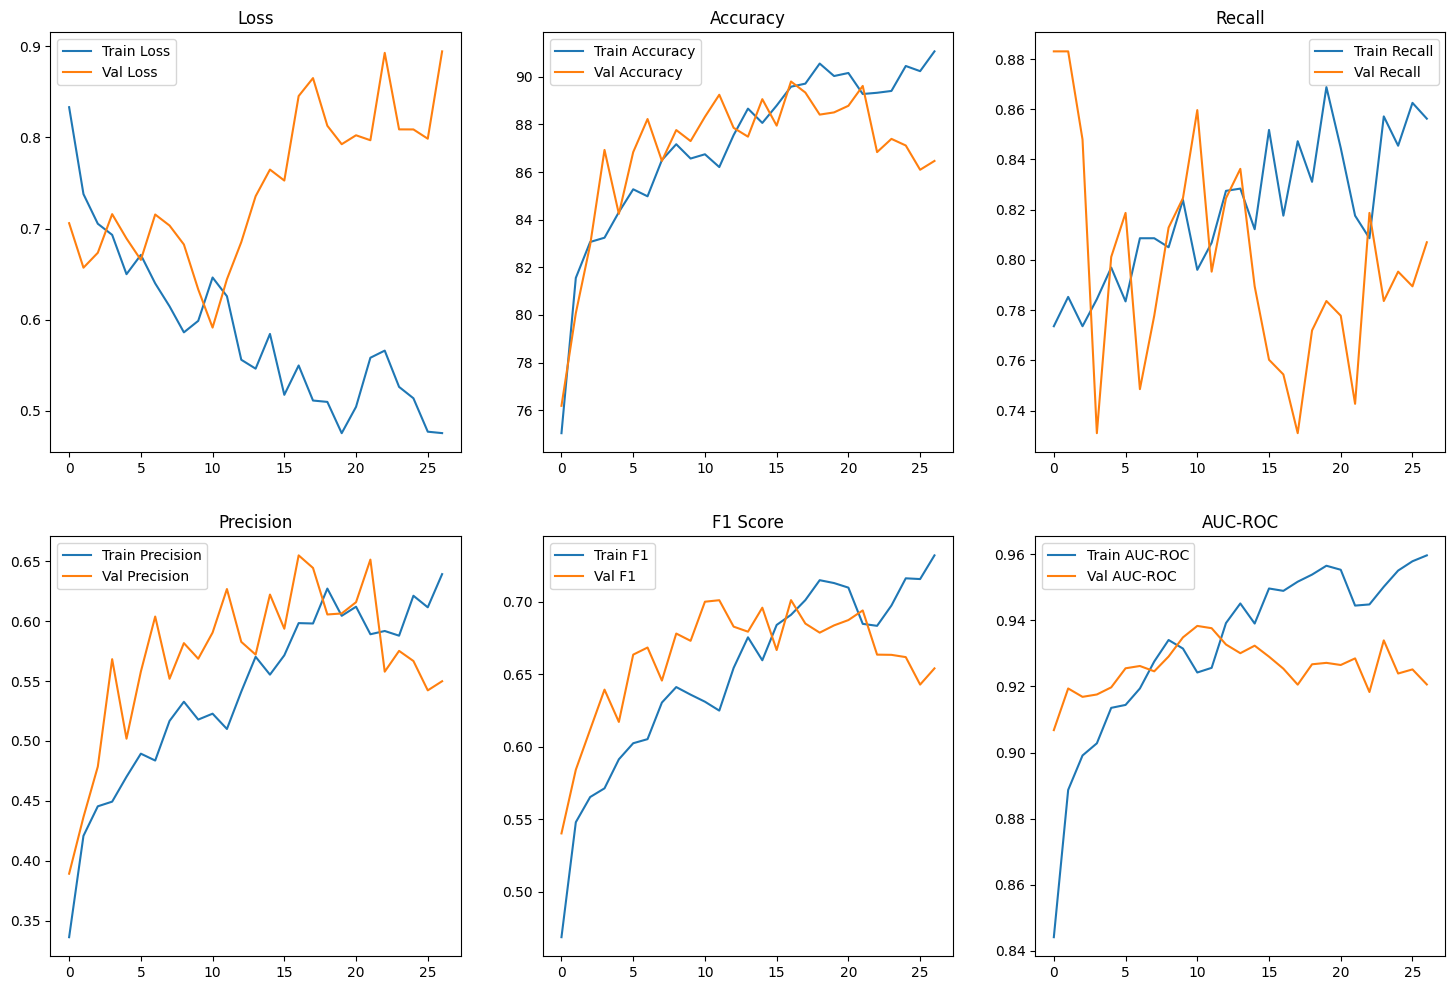

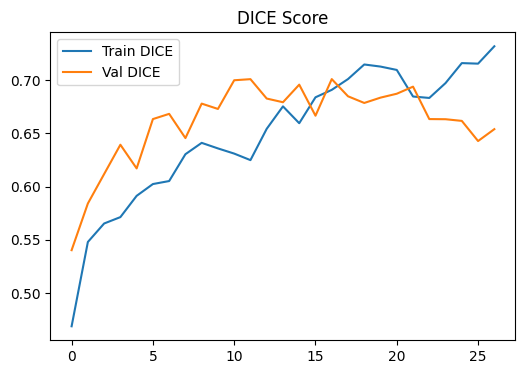

In [84]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(18, 12))
    
    # Gráfico de pérdida
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    # Gráfico de accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    # Gráfico de recall
    plt.subplot(2, 3, 3)
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.legend()
    
    # Gráfico de precision
    plt.subplot(2, 3, 4)
    plt.plot(history['train_precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.legend()
    
    # Gráfico de F1
    plt.subplot(2, 3, 5)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()
    
    # Gráfico de AUC-ROC
    plt.subplot(2, 3, 6)
    plt.plot(history['train_aucroc'], label='Train AUC-ROC')
    plt.plot(history['val_aucroc'], label='Val AUC-ROC')
    plt.title('AUC-ROC')
    plt.legend()
    
    # Gráfico de DICE
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_dice'], label='Train DICE')
    plt.plot(history['val_dice'], label='Val DICE')
    plt.title('DICE Score')
    plt.legend()
    plt.show()

# Mostrar gráficos
plot_history(history[0])  # Access the first element of the tuple, which is the dictionary

In [85]:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.show()

In [86]:

# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()  # Modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            preds = torch.round(torch.sigmoid(outputs))  # Convertir logits en 0 o 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

                  precision    recall  f1-score   support

   benign_images       0.95      0.93      0.94       908
malignant_images       0.65      0.75      0.70       171

        accuracy                           0.90      1079
       macro avg       0.80      0.84      0.82      1079
    weighted avg       0.91      0.90      0.90      1079



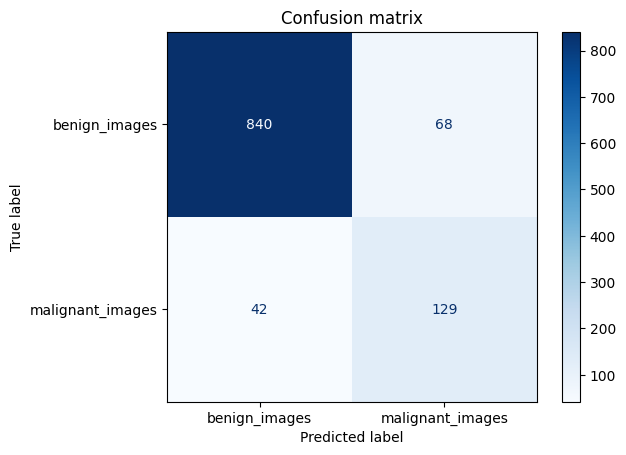

In [87]:

# Evaluar el modelo
all_labels, all_preds = evaluate_model(model, test_loader)
# Imprimir métricas
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
# Graficar matriz de confusión
plot_confusion_matrix(all_labels, all_preds, classes=train_dataset.classes)

In [88]:
torch.save(model.state_dict(), 'melanoma_model_1_torch_EFFICIENTNETB0_harvard_attention.pth')

In [89]:
import cv2
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Aplicar las mismas transformaciones

    with torch.no_grad():
        output = model(img).squeeze()
        prediction = torch.sigmoid(output).item()
    
    if prediction > 0.5:
        print("🔴 Malignant melanoma")
    else:
        print("🟢 Benign melanoma")

# Prueba con una imagen nueva
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\train\benign_images\ISIC_0024306.jpg', model)  # Benigno
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg', model)  # Maligno

🟢 Benign melanoma
🔴 Malignant melanoma


Utilizando dispositivo: cuda
Cargando checkpoint desde: C:\Users\jakif\CODE\PROYECTO-FINAL\COMPUTER_VISION\best_model_EFFICIENTB0_improved_2_attention.pth
Contenido del checkpoint:
  - epoch
  - model_state_dict
  - optimizer_state_dict
  - scheduler_state_dict
  - val_f1
  - val_loss
✅ Modelo cargado desde model_state_dict
Modelo entrenado por 16 épocas
F1 Score en validación: 0.7011
Capa objetivo para GradCAM: Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
Analizando imagen: C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy\test\malignant_images\ISIC_0034572.jpg
✅ Imagen cargada y transformada: torch.Size([1, 3, 224, 224])
Clase predicha: 1 (Probabilidad: 0.9931)
Interpretación: Maligno
✅ GradCAM generado con éxito
Forma de imagen original: (224, 224, 3)
Forma del mapa de calor: (224, 224, 3)


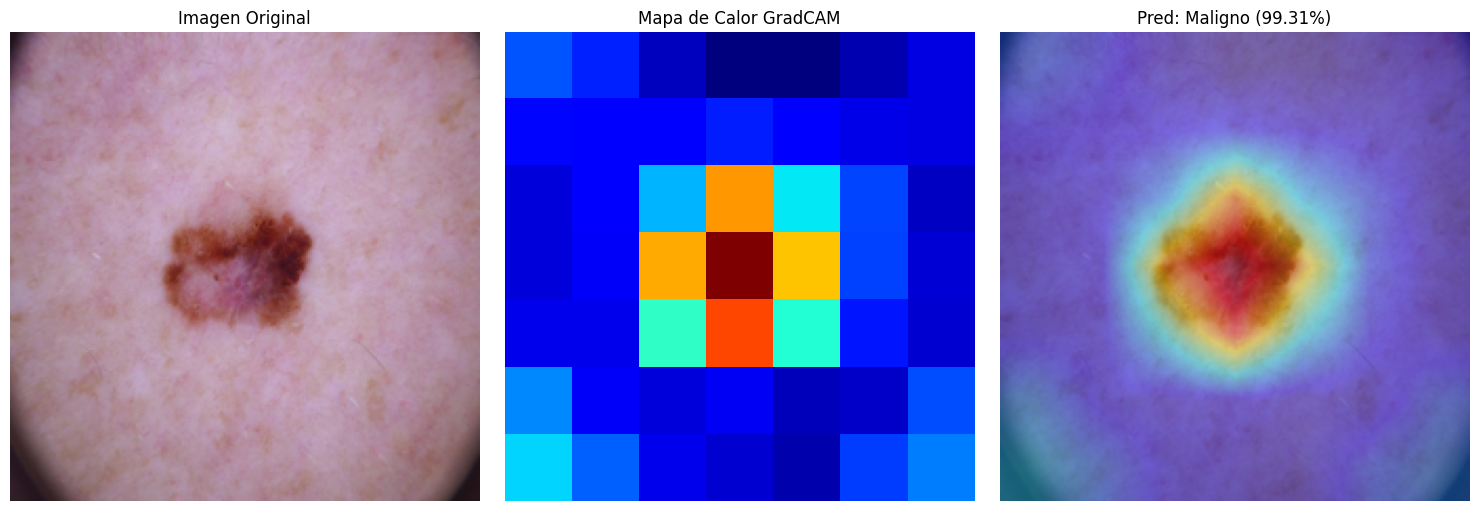

Resultado guardado en: gradcam_se_result.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Implementación GradCAM con SEEfficientNet-B0
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import os

# Definir la clase para el bloque Squeeze-and-Excitation
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze: Global Average Pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),  # Reducción de dimensionalidad
            nn.ReLU(inplace=True),  # Activación
            nn.Linear(channel // reduction, channel, bias=False),  # Restauración de dimensionalidad
            nn.Sigmoid()  # Escala entre 0 y 1 para recalibración
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)  # [B, C, H, W] -> [B, C, 1, 1] -> [B, C]
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)  # [B, C] -> [B, C, 1, 1]
        # Recalibración: multiplicación de canales por sus pesos
        return x * y.expand_as(x)  # Broadcast y multiplicar

# Clase para EfficientNet con bloques SE
class SEEfficientNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SEEfficientNet, self).__init__()
        # Cargar modelo base preentrenado
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        
        # Obtener la capa de características del EfficientNet
        self.features = self.base_model.features
        
        # Añadir bloques SE a cada bloque de características
        # EfficientNet-B0 tiene 9 bloques (del 0 al 8)
        for i in range(len(self.features)):
            # Obtenemos el número de canales del bloque actual
            if hasattr(self.features[i], 'block'):
                # Si es un MBConvBlock, añadir SE a nivel de bloque
                channels = self.features[i]._blocks[-1].project_conv.out_channels
                # Insertar un bloque SE después de cada MBConvBlock
                se_block = SEBlock(channels)
                # Guardamos el bloque SE en el módulo para que pueda ser accedido durante forward
                setattr(self, f'se_block_{i}', se_block)
        
        # Capa de clasificación más compleja con dropout y capas intermedias
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  # Dropout para regularización
            nn.Linear(in_features=1280, out_features=512),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=num_classes)  # Salida final (binaria)
        )
    
    def forward(self, x):
        # Pasar por cada bloque de features y aplicar SE donde corresponda
        for i in range(len(self.features)):
            # Aplicar el bloque convolucional
            x = self.features[i](x)
            # Si tiene un bloque SE asociado, aplicarlo
            if hasattr(self, f'se_block_{i}'):
                se_block = getattr(self, f'se_block_{i}')
                x = se_block(x)
        
        # Global average pooling y flatten
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        # Clasificador
        return self.classifier(x)

# Clase GradCam sin cambios
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        return self.model(x)

    def get_cam(self):
        # Ensure gradients and activations are available
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Perform a backward pass first.")

        # Move gradients and activations to the same device
        device = self.activations.device
        gradients = self.gradients.to(device)

        # Global Average Pooling
        weights = torch.mean(gradients, dim=[0, 2, 3])
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)

        for i in range(weights.shape[0]):
            cam += weights[i] * self.activations[0, i, :, :]

        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().detach().numpy()
  
# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizando dispositivo: {device}")

# Definir transformaciones para la imagen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Añadimos una conversión a RGB antes de la normalización
    transforms.Lambda(lambda x: x[:3] if x.shape[0] > 3 else x),  # Mantener solo los canales RGB si hay más
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear el modelo SEEfficientNet
model = SEEfficientNet(num_classes=1)

# Mover el modelo al dispositivo
model = model.to(device)

# Cargar los pesos del modelo desde un checkpoint
checkpoint_path = r'C:\Users\jakif\CODE\PROYECTO-FINAL\COMPUTER_VISION\best_model_EFFICIENTB0_improved_2_attention.pth'
print(f"Cargando checkpoint desde: {checkpoint_path}")

try:
    # Verificar si el archivo existe
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ ADVERTENCIA: No se encontró el archivo {checkpoint_path}")
        print("⚠️ Este script asume que ya has entrenado el modelo SE previamente")
        print("⚠️ Continuando con pesos no entrenados (solo para demostración)")
    else:
        # Cargar checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Verificar el contenido del checkpoint
        print("Contenido del checkpoint:")
        for key in checkpoint.keys():
            print(f"  - {key}")
        
        # Si el checkpoint contiene 'model_state_dict', este es el formato habitual de guardado
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("✅ Modelo cargado desde model_state_dict")
            
            # Opcionalmente, puedes imprimir información adicional
            if 'epoch' in checkpoint:
                print(f"Modelo entrenado por {checkpoint['epoch']} épocas")
            if 'val_f1' in checkpoint:
                print(f"F1 Score en validación: {checkpoint['val_f1']:.4f}")
        else:
            # Intentar cargar directamente como state_dict
            model.load_state_dict(checkpoint)
            print("✅ Modelo cargado directamente desde state_dict")
    
except Exception as e:
    print(f"❌ Error al cargar el modelo: {str(e)}")
    print("⚠️ Continuando con pesos preentrenados de ImageNet solamente")

# Poner modelo en modo evaluación
model.eval()

# Obtener la última capa convolucional para GradCAM
# En SEEfficientNet, vamos a usar la última capa de features
try:
    # Intentar obtener la última capa de features
    target_layer = model.features[-1]
    print(f"Capa objetivo para GradCAM: {target_layer}")
except Exception as e:
    print(f"Error al acceder a la capa objetivo: {str(e)}")
    # Fallback a otra capa
    try:
        # Intentar con la penúltima capa
        target_layer = model.features[-2]
        print(f"Usando capa alternativa: {target_layer}")
    except:
        print("No se pudo encontrar una capa adecuada para GradCAM")
        raise

# Crear el objeto GradCam
grad_cam = GradCam(model, target_layer)

# Ruta a la imagen (ajusta según sea necesario)
# Usaremos una imagen de ejemplo si la ruta específica no existe
default_image_path = r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy\test\malignant_images\ISIC_0034572.jpg'

# Buscar imágenes alternativas si la ruta predeterminada no existe
if not os.path.exists(default_image_path):
    print(f"⚠️ ADVERTENCIA: No se encontró la imagen en {default_image_path}")
    
    # Intentar encontrar cualquier imagen en el directorio actual
    current_dir = os.getcwd()
    print(f"Buscando imágenes en el directorio actual: {current_dir}")
    
    image_files = []
    for file in os.listdir(current_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            image_files.append(os.path.join(current_dir, file))
    
    if image_files:
        image_path = image_files[0]
        print(f"✅ Se usará esta imagen alternativa: {image_path}")
    else:
        raise FileNotFoundError("No se encontraron imágenes en el directorio actual. Por favor, especifica una ruta de imagen válida.")
else:
    image_path = default_image_path
    print(f"Analizando imagen: {image_path}")

# Cargar y preprocesar la imagen
try:
    # Verificación final antes de intentar abrir la imagen
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"La imagen no existe en la ruta: {image_path}")
    
    # Abrir la imagen
    image = Image.open(image_path)
    
    # Conversión explícita a RGB (por si la imagen es RGBA o tiene un formato diferente)
    if image.mode != 'RGB':
        print(f"⚠️ La imagen está en modo {image.mode}, convirtiendo a RGB...")
        image = image.convert('RGB')
    
    # IMPORTANTE: NO usamos with torch.no_grad() aquí porque necesitamos gradientes para GradCAM
    image_tensor = transform(image).unsqueeze(0).to(device)
    print(f"✅ Imagen cargada y transformada: {image_tensor.shape}")
except Exception as e:
    print(f"❌ Error al cargar la imagen: {str(e)}")
    print("\nSugerencias para solucionar este problema:")
    print("1. Revisa que la ruta de la imagen sea correcta")
    print("2. Coloca una imagen en el directorio donde estás ejecutando este script")
    print("3. Verifica que la imagen tenga un formato compatible (jpg, png)")
    print("4. Asegúrate de que la imagen sea RGB y no RGBA u otro formato")
    raise

# Para GradCAM necesitamos habilitar el tracking de gradientes
# Aseguramos que requires_grad está habilitado
image_tensor.requires_grad = True

# Forward pass
outputs = model(image_tensor)

# Obtener la clase predicha
predicted_prob = torch.sigmoid(outputs.squeeze()).item()
predicted_class = 1 if predicted_prob >= 0.5 else 0
print(f"Clase predicha: {predicted_class} (Probabilidad: {predicted_prob:.4f})")
print(f"Interpretación: {'Maligno' if predicted_class == 1 else 'Benigno'}")

# Backward pass para calcular gradientes
model.zero_grad()

# Crear un tensor para propagar hacia atrás
if outputs.requires_grad:
    outputs.backward(retain_graph=True)
else:
    print("⚠️ ADVERTENCIA: El tensor de salida no tiene gradientes. Intentando solución alternativa...")
    # Creamos una salida que requiera gradientes
    output_with_grad = outputs.detach().requires_grad_(True)
    output_with_grad.backward(torch.ones_like(output_with_grad))

# Obtener el mapa de activación de clase
try:
    cam = grad_cam.get_cam()
    print("✅ GradCAM generado con éxito")
except Exception as e:
    print(f"❌ Error al generar GradCAM: {str(e)}")
    # En caso de error, crear un mapa de calor vacío
    cam = np.zeros((224, 224))
    print("⚠️ Se generará un mapa de calor vacío")

# Mostrar resultados
plt.figure(figsize=(15, 5))

# Imagen original
plt.subplot(1, 3, 1)
original_image = Image.open(image_path)
original_image_resized = original_image.resize((224, 224))
plt.imshow(original_image_resized)
plt.title("Imagen Original")
plt.axis('off')

# Mapa de calor de GradCAM
plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Mapa de Calor GradCAM")
plt.axis('off')

# Superposición del mapa de calor sobre la imagen original
plt.subplot(1, 3, 3)
original_image_np = np.array(original_image_resized)

# Asegurarse de que tanto la imagen original como el mapa de calor tengan las mismas dimensiones
cam_resized = cv2.resize(cam, (original_image_np.shape[1], original_image_np.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Asegurarse de que ambas imágenes tengan el mismo número de canales
if len(original_image_np.shape) == 2:  # Si la imagen es en escala de grises
    original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_GRAY2RGB)
elif original_image_np.shape[2] == 4:  # Si la imagen tiene canal alpha (RGBA)
    original_image_np = original_image_np[:, :, :3]  # Descartar el canal alpha

# Asegurarse de que ambas imágenes sean del mismo tipo
original_image_np = original_image_np.astype(np.uint8)
heatmap = heatmap.astype(np.uint8)

# Verificar y mostrar las formas antes de la superposición
print(f"Forma de imagen original: {original_image_np.shape}")
print(f"Forma del mapa de calor: {heatmap.shape}")

# Realizar la superposición
try:
    overlay = cv2.addWeighted(original_image_np, 0.6, heatmap, 0.4, 0)
    plt.imshow(overlay)
except Exception as e:
    print(f"Error en la superposición: {str(e)}")
    # Alternativa: mostrar solo el mapa de calor si falla la superposición
    plt.imshow(heatmap)
    print("⚠️ Mostrando solo el mapa de calor debido a un error de superposición")

plt.title(f"Pred: {'Maligno' if predicted_class == 1 else 'Benigno'} ({predicted_prob:.2%})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Guardar la imagen resultante
result_path = "gradcam_se_result.png"
plt.savefig(result_path)
print(f"Resultado guardado en: {result_path}")

# Limpiar memoria
del model
del grad_cam
torch.cuda.empty_cache()